### SVM classification, multiclass classification model

In [22]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.calibration import CalibratedClassifierCV

In [23]:
# load iris as the test dataset
df = sns.load_dataset("iris")

In [24]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa


In [25]:
# not much data, but it's balanced
df['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [26]:
# no missing values it seems
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(1)

In [28]:
# drop duplicate values
df = df.drop_duplicates()

### X/y -split + VIF

In [29]:
# a small trick => use everything else except, the target
X = df.drop("species", axis=1)

# our target variable is y
y = df["species"]

#### Train/test-split and scaling is still the same...

In [30]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### ... but model training etc. is a bit different in multinomial situation

In [31]:
# since we are using multinomial logistic regression
# we have to use multi_class -parameter AND A SOLVER
# that supports multi-class 
model = make_pipeline(StandardScaler(), svm.SVC(probability=True))
model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('standardscaler', ...), ('svc', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


### Classification error metrics

In [32]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [33]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.93      1.00      0.96        13
   virginica       1.00      0.95      0.97        20

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45


Model overall accuracy: 97.78%


In [34]:
df['species'].unique()

<StringArray>
['setosa', 'versicolor', 'virginica']
Length: 3, dtype: str

In [35]:
# save the actual names of the target values 
# so our confusion matrix is easier to read
labels = ['setosa', 'versicolor', 'virginica']

[[12  0  0]
 [ 0 13  0]
 [ 0  1 19]]


<Axes: >

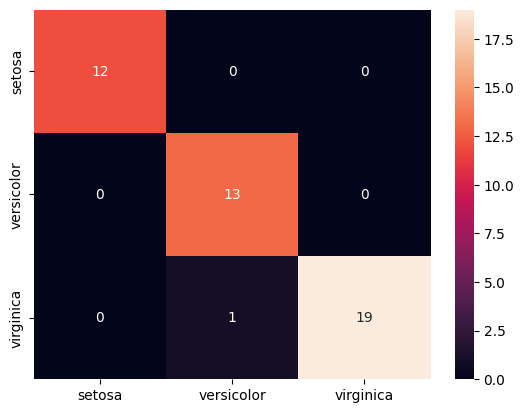

In [36]:
print(confusion_matrix(y_test, predictions))

# use seaborn and labels to make a better confusion matrix
# basically we wrap the confusion matrix into a pandas DataFrame
cm_array = confusion_matrix(y_test, predictions)
cm_array_df = pd.DataFrame(cm_array, index=labels, columns=labels)
sns.heatmap(cm_array_df, annot=True, fmt='g')

In [37]:
# The AUC score is a super sensitive metric
# you often get low scores, even 0.5

# in binary logistic regression, AUC values are often interpreted as follows:
# A binary classifier is useful only when it achieves ROC-AUC score greater than 0.5 and as near to 1 as possible. 
# If a classifier yields a score less than 0.5, it simply means that the model is performing worse 
# than a random classifier, and therefore is useless.

# In multinomial logistic regression , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# basically 0.5 means, there's still something to optimize
# if this falls under 0.5, random guessing works better than this model

# in multiclass situations, use multi_clas="ovr" as the parameter
roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")

1.0

<Axes: xlabel='sepal_length', ylabel='petal_length'>

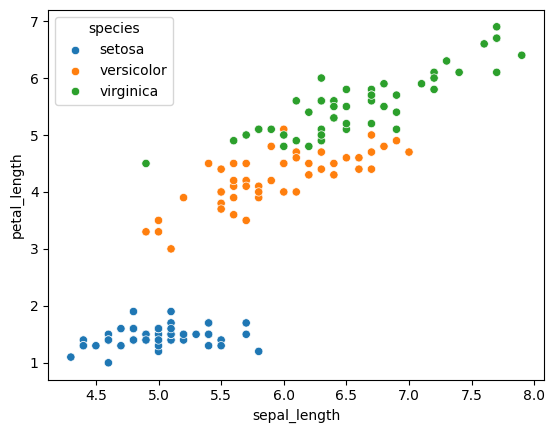

In [38]:
sns.scatterplot(x="sepal_length", y='petal_length', data=df, hue="species")

### Let's try the model in practice with a new flower

In [39]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.70,3.00,5.20,2.30,virginica
146,6.30,2.50,5.00,1.90,virginica
147,6.50,3.00,5.20,2.00,virginica
148,6.20,3.40,5.40,2.30,virginica
149,5.90,3.00,5.10,1.80,virginica


In [40]:
df.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='str')

In [41]:
# switch to decimal format in probabilities
# default is scientific notation (which is more difficult to read)
np.set_printoptions(suppress=True) 
pd.set_option('display.float_format', '{:.2f}'.format)  

In [42]:
# 6.70	3.00	5.20	2.30	virginica
tester_row = {
    'sepal_length': 7.1, 
    'sepal_width': 3.2, 
    'petal_length': 5.7, 
    'petal_width': 2.05
}

# create a pandas DataFrame and scale the values
tester_row = pd.DataFrame([tester_row])


# create prediction values for categories
prediction = model.predict_proba(tester_row)

print("All probabilities by category:")
print(labels)
print(prediction)
print()

# change these based on your original data
labels = ['setosa', 'versicolor', 'virginica']

# get index of highest probability with NumPy's argmax()-function
result_index = np.argmax(prediction)

print("Detected flower species:")
result = labels[result_index]
print(result)
print("-------------------")

All probabilities by category:
['setosa', 'versicolor', 'virginica']
[[0.00943316 0.0147377  0.97582914]]

Detected flower species:
virginica
-------------------
